# DsDA Controller

Creates multiple dataset and runs them through the DsDA method

In [2]:
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import sys
import scipy.stats
import pylab as plt
from IPython import display
import pylab as plt
import glob

In [8]:
sys.path.append('..\\..')

In [9]:
from vimms.Chemicals import *
from vimms.Chromatograms import *
from vimms.MassSpec import *
from vimms.Controller import *
from vimms.Common import *
from vimms.DataGenerator import *
from vimms.DsDA import *

In [10]:
 set_log_level_warning()
# set_log_level_info()
# set_log_level_debug()

Load densities trained on 19 beer data (see [loader_kde](loader_kde.ipynb)).

In [11]:
base_dir = '..\\..'

In [12]:
ps = load_obj(os.path.join(base_dir, 'data\\peak_sampler_mz_rt_int_19_beers_fragmentation.p'))

In [13]:
hmdb = load_obj(os.path.join(base_dir, 'data\\hmdb_compounds.p'))

# Updated Chemical Creator

In [27]:
ROI_Sources = ["C:\\Users\\Vinny\\OneDrive - University of Glasgow\\Glasgow\\DsDA\\DsDA_Beer\\beer_t10_simulator_files"]
min_ms1_intensity = 1.75E5
rt_range = [(0, 1260)]
mz_range = [(0, 1050)]
n_peaks = 6500
chems = ChemicalCreator(ps, ROI_Sources, hmdb)
dataset = chems.sample(mz_range, rt_range, min_ms1_intensity, n_peaks, 2, use_database=False, fixed_mz=False)

# Create Multiple Datasets for DsDA

In [28]:
n_samples = [20]
classes = ["class1"]
intensity_noise_sd = [10000]
change_probabilities = None
change_differences_means = None
change_differences_sds = None
dropout_probabilities = None 
experimental_classes = None 
experimental_probabilitities = None 
experimental_sds = None
save_location = 'C:\\Users\\Vinny\\OneDrive - University of Glasgow\\Glasgow\\DsDA\\DsDA_Simulator\\Samples\\'

multiple_samples = MultiSampleCreator(dataset, n_samples, classes, intensity_noise_sd, 
                                      change_probabilities, change_differences_means, change_differences_sds, dropout_probabilities,
                                     experimental_classes, experimental_probabilitities, experimental_sds, save_location=save_location)

Saving <class 'list'> to C:\Users\Vinny\OneDrive - University of Glasgow\Glasgow\DsDA\DsDA_Simulator\Samples\\sample_0.p
Saving <class 'list'> to C:\Users\Vinny\OneDrive - University of Glasgow\Glasgow\DsDA\DsDA_Simulator\Samples\\sample_1.p
Saving <class 'list'> to C:\Users\Vinny\OneDrive - University of Glasgow\Glasgow\DsDA\DsDA_Simulator\Samples\\sample_2.p
Saving <class 'list'> to C:\Users\Vinny\OneDrive - University of Glasgow\Glasgow\DsDA\DsDA_Simulator\Samples\\sample_3.p
Saving <class 'list'> to C:\Users\Vinny\OneDrive - University of Glasgow\Glasgow\DsDA\DsDA_Simulator\Samples\\sample_4.p
Saving <class 'list'> to C:\Users\Vinny\OneDrive - University of Glasgow\Glasgow\DsDA\DsDA_Simulator\Samples\\sample_5.p
Saving <class 'list'> to C:\Users\Vinny\OneDrive - University of Glasgow\Glasgow\DsDA\DsDA_Simulator\Samples\\sample_6.p
Saving <class 'list'> to C:\Users\Vinny\OneDrive - University of Glasgow\Glasgow\DsDA\DsDA_Simulator\Samples\\sample_7.p
Saving <class 'list'> to C:\User

In [29]:
min_rt = 0
max_rt = 1440 
mzml_dir = 'C:\\Users\\Vinny\\OneDrive - University of Glasgow\\Glasgow\\DsDA\\DsDA_Simulator\\Samples\\mzML\\'
for i in range(n_samples[0]):
    sample = load_obj('C:\\Users\\Vinny\\OneDrive - University of Glasgow\\Glasgow\\DsDA\\DsDA_Simulator\\Samples\\sample_' + '%d.p' % i)
    mass_spec = IndependentMassSpectrometer(POSITIVE, sample, density=ps.density_estimator)
    controller = SimpleMs1Controller(mass_spec)
    controller.run(min_rt,max_rt)
    controller.write_mzML('my_analysis', mzml_dir + '\\%d.mzML' % i)

1440.1140399999788it [00:45, 31.65it/s]                                                                                                                                                                                                      
1440.2080899999864it [00:44, 32.08it/s]                                                                                                                                                                                                      
1440.0747599999847it [00:43, 32.90it/s]                                                                                                                                                                                                      
1440.2050799999838it [00:50, 28.79it/s]                                                                                                                                                                                                      
1440.1657999999877it [00:57, 25.25it/s]         

# Run DsDA on Simulator Data

In [14]:
schedule_dir = 'C:\\Users\\Vinny\\OneDrive - University of Glasgow\\Glasgow\\DsDA\\DsDA_Simulator\\settings'
data_dir = 'C:\\Users\\Vinny\\OneDrive - University of Glasgow\\Glasgow\\DsDA\\DsDA_Simulator\\Data'
controllers_dir = 'C:\\Users\\Vinny\\OneDrive - University of Glasgow\\Glasgow\\DsDA\\DsDA_Simulator\\controllers'
t4_controllers_dir = 'C:\\Users\\Vinny\\OneDrive - University of Glasgow\\Glasgow\\DsDA\\DsDA_Simulator\\T4_controllers'

In [15]:
isolation_window = 1   # the isolation window in Dalton around a selected precursor ion
min_ms1_intensity = 1.75E5 # minimum ms1 intensity to fragment
min_rt = 3*60
max_rt = 21*60
N = 4
rt_tol = 15
mz_tol = 10

In [ ]:
initial_schedule = get_schedule(1, t4_controllers_dir)
print("start")
n_samples = 3
for n in range(n_samples):
    dataset = load_obj('C:\\Users\\Vinny\\OneDrive - University of Glasgow\\Glasgow\\DsDA\\DsDA_Simulator\\Samples\\sample_%d.p' % n)
    if n == 0:
        mass_spec = IndependentMassSpectrometer(POSITIVE, dataset, density=ps.density_estimator, schedule_file=initial_schedule)
        controller = TopNController(mass_spec, N, isolation_window, mz_tol, rt_tol, min_ms1_intensity)
        controller.run()
    else:
        last_schedule = get_schedule(n, schedule_dir)
        mass_spec = DsDAMassSpec(POSITIVE, dataset, density=ps.density_estimator)
        controller = DsDAController(mass_spec, 1, 0.5, 15, 2E5)
        controller.run(last_schedule)
    print("Processed ", n+1, " files")
    if n == 0:
        print("Run R File")
        print("When asked, select the DsDA_Test location")
    controller.write_mzML('my_analysis', data_dir + '\\%d.mzML' % n)
    save_obj(controller, controllers_dir + '\\%d.p' % n)

# Code to Analyse Simulated Data

In [18]:
t4_controller_directory = 'C:\\Users\\Vinny\\OneDrive - University of Glasgow\\Glasgow\\DsDA\\T4_Simulator'
dsda_controller_directory = 'C:\\Users\\Vinny\\OneDrive - University of Glasgow\\Glasgow\\DsDA\\DsDA_Simulator\\controllers'
dsda_maxdepth_controller_directory = 'C:\\Users\\Vinny\\OneDrive - University of Glasgow\\Glasgow\\DsDA\\DsDA_Simulator_MaxDepth\\controllers'

In [21]:
T4_perf = fragmentation_performance_chemicals(t4_controller_directory, min_acceptable_intensity=1.75E5)
DsDA_perf = fragmentation_performance_chemicals(dsda_controller_directory, min_acceptable_intensity=1.75E5)
DsDA_maxdepth_perf = fragmentation_performance_chemicals(dsda_maxdepth_controller_directory, min_acceptable_intensity=1.75E5)

Completed Controller 1
Completed Controller 2
Completed Controller 3
Completed Controller 4
Completed Controller 5
Completed Controller 6
Completed Controller 7
Completed Controller 8
Completed Controller 9
Completed Controller 10
Completed Controller 11
Completed Controller 12
Completed Controller 13
Completed Controller 14
Completed Controller 15
Completed Controller 16
Completed Controller 17
Completed Controller 18
Completed Controller 19
Completed Controller 20
Completed Controller 1
Completed Controller 2
Completed Controller 3
Completed Controller 4
Completed Controller 5
Completed Controller 6
Completed Controller 7
Completed Controller 8
Completed Controller 9
Completed Controller 10
Completed Controller 11
Completed Controller 12
Completed Controller 13
Completed Controller 14
Completed Controller 15
Completed Controller 16
Completed Controller 17
Completed Controller 18
Completed Controller 19
Completed Controller 20
Completed Controller 1
Completed Controller 2
Completed Co

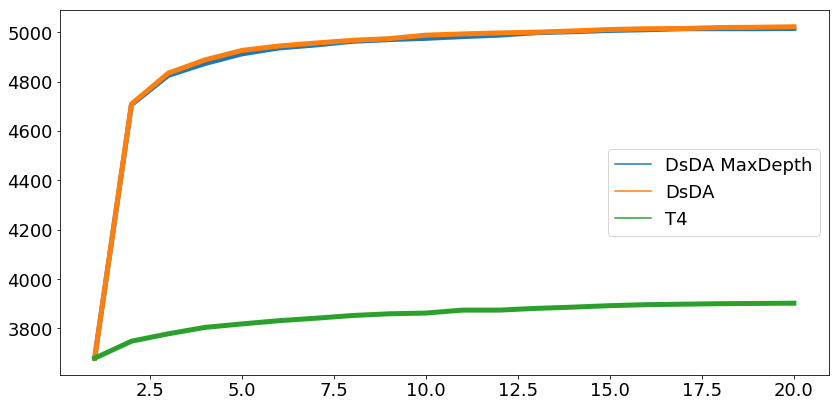

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(range(1,21,1),np.array(DsDA_maxdepth_perf[1]),label="DsDA MaxDepth")
plt.plot(range(1,21,1),np.array(DsDA_perf[1]),label="DsDA")
plt.plot(range(1,21,1),np.array(T4_perf[1]),label="T4")
plt.legend(loc='center right')
ax = plt.gca()
for l in ax.lines:
    plt.setp(l, linewidth=5)
plt.tight_layout()
plt.savefig('C:\\Users\\Vinny\\OneDrive - University of Glasgow\\Glasgow\\DsDA\\Figures\\dsda_simulated_chemicals.png', dpi=300)

alternative version

In [23]:
t4_controller_directory = 'C:\\Users\\Vinny\\OneDrive - University of Glasgow\\Glasgow\\DsDA\\T4_Simulator\\'
dsda_controller_directory = 'C:\\Users\\Vinny\\OneDrive - University of Glasgow\\Glasgow\\DsDA\\DsDA_Simulator\\controllers\\'
dsda_maxdepth_controller_directory = 'C:\\Users\\Vinny\\OneDrive - University of Glasgow\\Glasgow\\DsDA\\DsDA_Simulator_MaxDepth\\controllers\\'

aligned_simulator_chemicals = 'C:\\Users\\Vinny\\OneDrive - University of Glasgow\\Glasgow\\DsDA\\XCMS_Picked_Peaks\\simulated_aligned_features_ms1.csv'

params_t4 = create_frag_dicts(t4_controller_directory, aligned_simulator_chemicals, 1.75E5)
params_dsda = create_frag_dicts(dsda_controller_directory, aligned_simulator_chemicals, 1.75E5)
params_dsda_maxdepth = create_frag_dicts(dsda_maxdepth_controller_directory, aligned_simulator_chemicals, 1.75E5)

In [24]:
chemicals_found_results_t4 = multi_sample_fragmentation_performance_aligned(params_t4)
chemicals_found_results_dsda = multi_sample_fragmentation_performance_aligned(params_dsda)
chemicals_found_results_dsda_maxdepth = multi_sample_fragmentation_performance_aligned(params_dsda_maxdepth)

In [10]:
plt.rcParams.update({'font.size': 18})

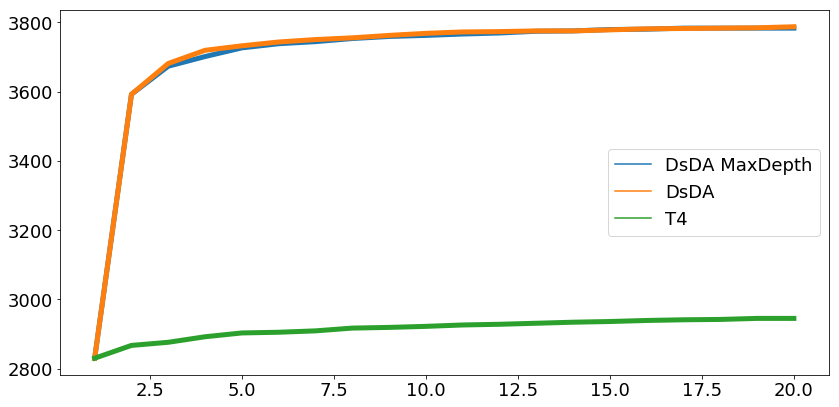

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(range(1,21,1),np.array(chemicals_found_results_dsda_maxdepth),label="DsDA MaxDepth")
plt.plot(range(1,21,1),np.array(chemicals_found_results_dsda),label="DsDA")
plt.plot(range(1,21,1),np.array(chemicals_found_results_t4),label="T4")
plt.legend(loc='center right')
ax = plt.gca()
for l in ax.lines:
    plt.setp(l, linewidth=5)
plt.tight_layout()
plt.savefig('C:\\Users\\Vinny\\OneDrive - University of Glasgow\\Glasgow\\DsDA\\Figures\\dsda_simulated_xcms.png', dpi=300)